# STAT 551
# Man Chong (Henry) Leong
# Vignette 2 - Spatial data visualization with ggplot2 and Interpolation for polygon level data - of House Hold Income in Harris County

## Goal

In Vignette 1, we found out that spatial patterns of Median Household income do exist in Houston. Can we fit statistical models based on these spatial patterns?

In this Vignette, we will see how to further visualize spatial data using ggplot2, and fit statistical models for prediction with polygon data.

First of all, the census dataset we are using here is from https://www.kinderudp.org/.

OGR data source with driver: ESRI Shapefile 
Source: "/Users/manchongleong/Desktop/STAT551", layer: "tl_2010_48_bg10"
with 15811 features
It has 15 fields
Integer64 fields read as strings:  OBJECTID 


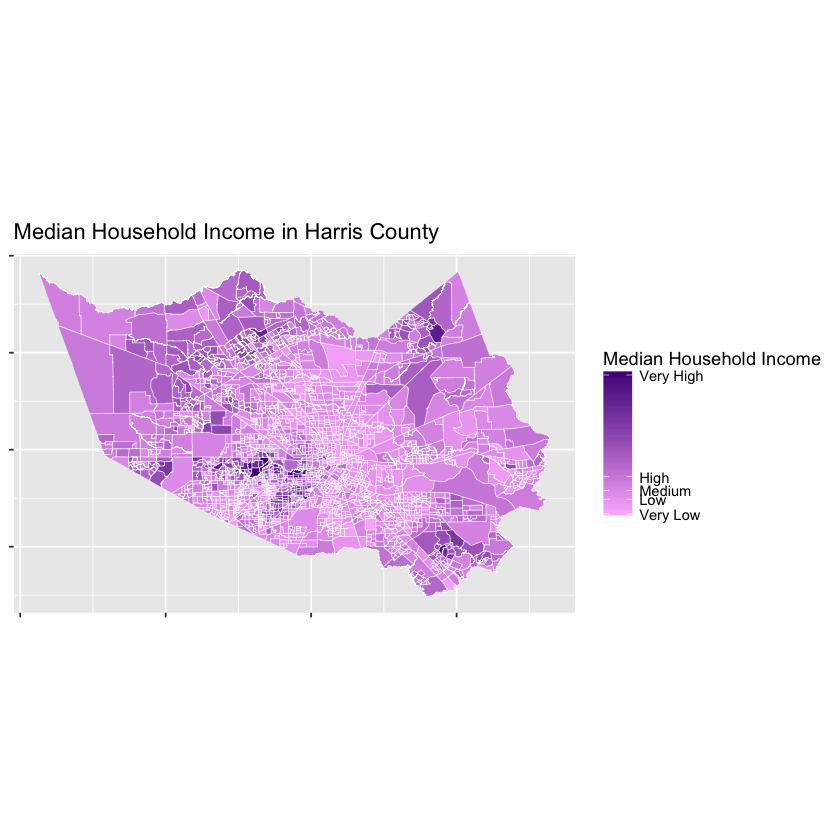

In [8]:
rm(list=ls())
library("rgdal")
library("dplyr")
library("data.table")
library("gstat")
library("tidyr")
library("spgwr")
library("spdep")
library("ggplot2")

# read datasets
censusData_bg <- data.table::fread("/Users/manchongleong/Desktop/STAT551/Curated/Cen2010Harris_BG_v01.csv",
                    colClasses = c(GeoID10_bg="chatacher",
                                   stfips="character",
                                   county="character",
                                   tract="character")) %>%
  dplyr::rename(GEOID10=GeoID10_bg)
# read census boundary
censusBoundary <- rgdal::readOGR(dsn="/Users/manchongleong/Desktop/STAT551/", 
                          layer="tl_2010_48_bg10")
# only get the records in Harris County
censusBoundary.harris <- censusBoundary[grepl(c("201"),
                                      censusBoundary@data$COUNTYFP10), ]

# merge boundary with census data
censusBoundary.harris <- censusBoundary.harris %>%
  merge(censusData_bg, by="GEOID10")

censusBoundary.harris@data$id <- rownames(censusBoundary.harris@data)

# remove na
censusBoundary.harris_clean <- censusBoundary.harris[!(is.na(censusBoundary.harris@data$MedHHinc)), ]

# might have outliers, create another dataset without outlier
# outside 1.5 times the interquartile 
# range above the upper quartile and bellow the lower quartile
censusBoundary.harris_clean_rm_ol <- censusBoundary.harris_clean[!(censusBoundary.harris_clean@data$MedHHinc %in% boxplot(censusBoundary.harris_clean@data$MedHHinc, plot=FALSE)$out), ]

# convert a spatial object into data.frame
HarrisCty.tidy <- ggplot2::fortify(censusBoundary.harris_clean, region="id")

HarrisCty.tidy_merge <- merge(HarrisCty.tidy, censusBoundary.harris_clean@data, by="id")

map_HarrisCty <- ggplot(data=HarrisCty.tidy_merge, aes(long,lat,group=group,fill=MedHHinc)) + 
  geom_polygon() +
  geom_path(color = "white", size=0.1) +
  scale_fill_gradient(low = "plum1", high = "purple4", 
                      breaks = quantile(censusBoundary.harris_clean@data$MedHHinc),
                     labels=c("Very Low", "Low", "Medium", "High", "Very High")) +
  coord_equal() +
  theme(axis.title = element_blank(), axis.text = element_blank()) +
  labs(title = "Median Household Income in Harris County", fill = "Median Household Income")

map_HarrisCty

Recall from Vignette 1, there are some outliers. How would these outliers affect interpolation? Should we remove them for interpolation?

## Interpolation for Median Household Income in Harris County using inverse weighted distance

Inverse weighted distance (IDW) should be one of the easiest method for interpolation. It is nothing special but to interpolate only based on distances of points.

[inverse distance weighted interpolation]


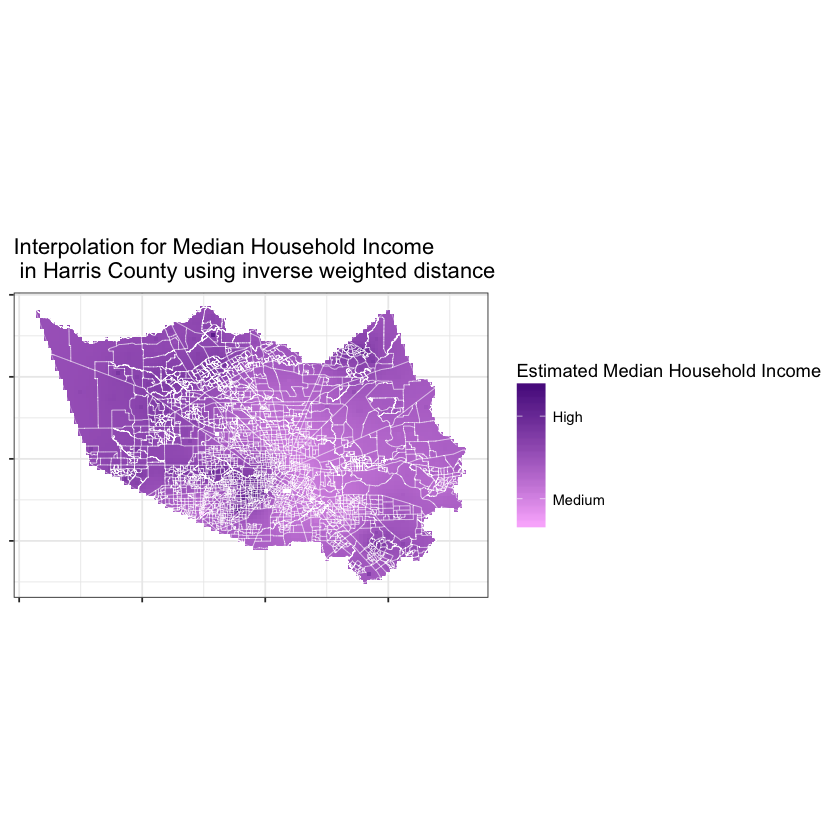

In [9]:

grid <-spsample(censusBoundary.harris_clean, type = 'regular', n = 5000)

Result_num.idw <- gstat::idw((MedHHinc)~1, 
                             location=censusBoundary.harris_clean, 
                             #newdata=harris.grid, 
                             newdata=grid,
                             idp=1) 

idw.output = as.data.frame(Result_num.idw) 

names(idw.output)[1:3] <- c("long", "lat", "prediction")

idw.output = as.data.frame(Result_num.idw) 
idw_plot <- ggplot() + 
  geom_tile(data = idw.output %>%
            rename(`Estimated Median Household Income`=var1.pred), 
            aes(x = x1, y = x2, fill = `Estimated Median Household Income`)) + 
  #scale_fill_distiller(palette = "Spectral", direction = 1) +
  scale_fill_gradient(low = "plum1", high = "purple4", 
                      breaks = quantile(censusBoundary.harris_clean@data$MedHHinc),
                      labels=c("Very Low", "Low", "Medium", "High", "Very High")) +
  theme_bw()  +
  coord_equal() 

# convert a spatial object into data.frame
HarrisCty.tidy <- ggplot2::fortify(censusBoundary.harris_clean, region="id")

HarrisCty.tidy_merge <- merge(HarrisCty.tidy, censusBoundary.harris_clean@data, by="id")

new_plot <- idw_plot +
  geom_path(data=HarrisCty.tidy_merge, aes(long,lat,group=group), 
            color = "white", size=0.1) +
  theme(axis.title = element_blank(), axis.text = element_blank()) +
  labs(title = "Interpolation for Median Household Income\n in Harris County using inverse weighted distance")

new_plot

These outliers "pull" all the estimated values up. Using the same break with the actual values, none of the estimated values belong to the groups below "Low". Also, there are no estimated values get close to "very high".

All in all, smoothing without dealing with outliers is a very bad idea.

What if the outliers get excluded?

[inverse distance weighted interpolation]


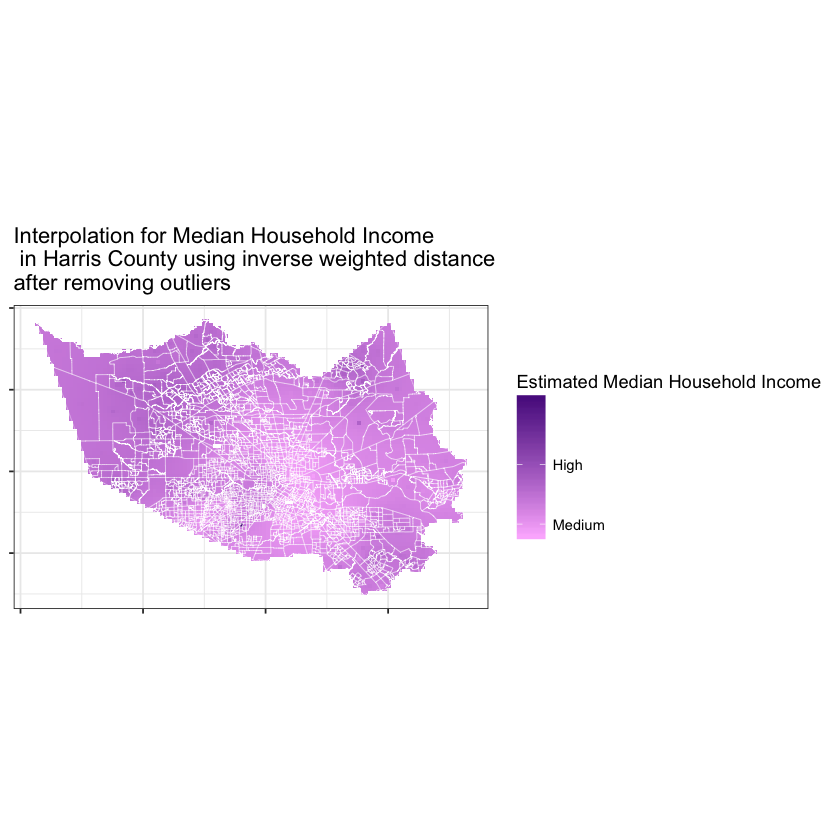

In [10]:

grid <-spsample(censusBoundary.harris_clean, type = 'regular', n = 5000)

Result_num.idw <- gstat::idw((MedHHinc)~1, 
                             location=censusBoundary.harris_clean_rm_ol, 
                             #newdata=harris.grid, 
                             newdata=grid,
                             idp=1) 

# grab output of IDW for plotting
idw.output = as.data.frame(Result_num.idw)  # output is defined as a data table
# set the names of the idw.output columns
# basic ggplot using geom_tile to display our interpolated grid within no map
idw_plot <- ggplot() + 
  geom_tile(data = idw.output %>%
            rename(`Estimated Median Household Income`=var1.pred), 
            aes(x = x1, y = x2, fill = `Estimated Median Household Income`)) + 
  #scale_fill_distiller(palette = "Spectral", direction = 1) +
  scale_fill_gradient(low = "plum1", high = "purple4", 
                      breaks = quantile(censusBoundary.harris_clean_rm_ol@data$MedHHinc),
                      labels=c("Very Low", "Low", "Medium", "High", "Very High")) +
  theme_bw()  +
  coord_equal() 

# convert a spatial object into data.frame
HarrisCty.tidy <- ggplot2::fortify(censusBoundary.harris_clean, region="id")

HarrisCty.tidy_merge <- merge(HarrisCty.tidy, censusBoundary.harris_clean@data, by="id")

new_plot <- idw_plot +
  geom_path(data=HarrisCty.tidy_merge, aes(long,lat,group=group), 
            color = "white", size=0.1) +
  theme(axis.title = element_blank(), axis.text = element_blank()) +
  labs(title = "Interpolation for Median Household Income\n in Harris County using inverse weighted distance\nafter removing outliers")

new_plot

After removing outliers, the interpolation becomes much smoother. However, is it really better than including outliers? 

This question is arguable. When the targets that we are interested in are those outliers or related to those outliers, including them might not be a bad idea. However, if we are more interested in the general picture, not specific patterns, then removing outliers will be a better choice. 

## Kriging

Recall from Vignette 1:

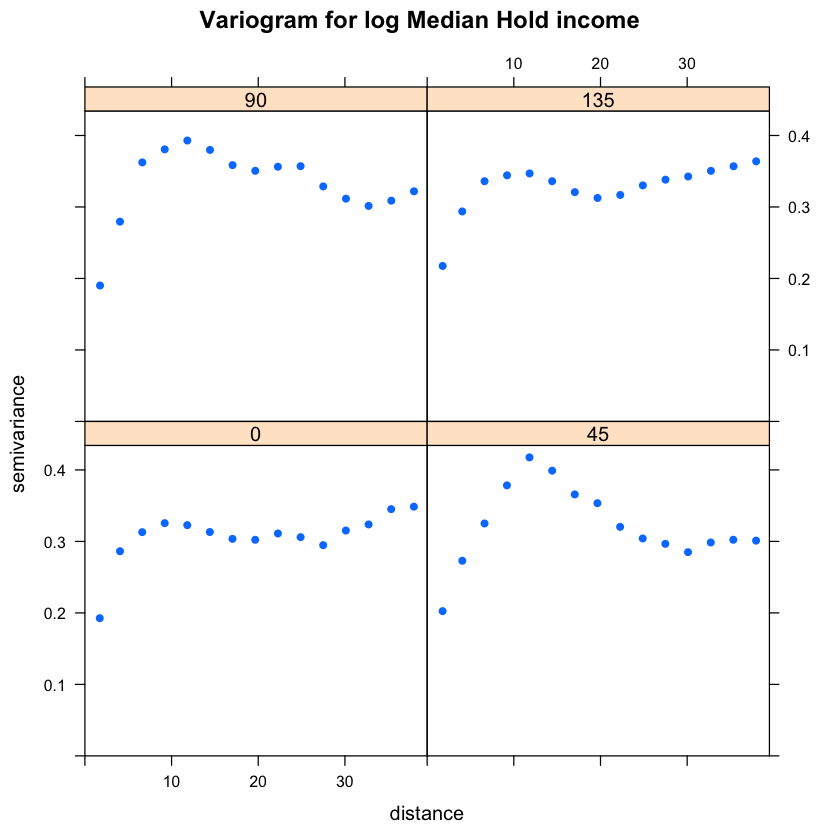

  model     psill    range
1   Sph 0.2369033 3.537678


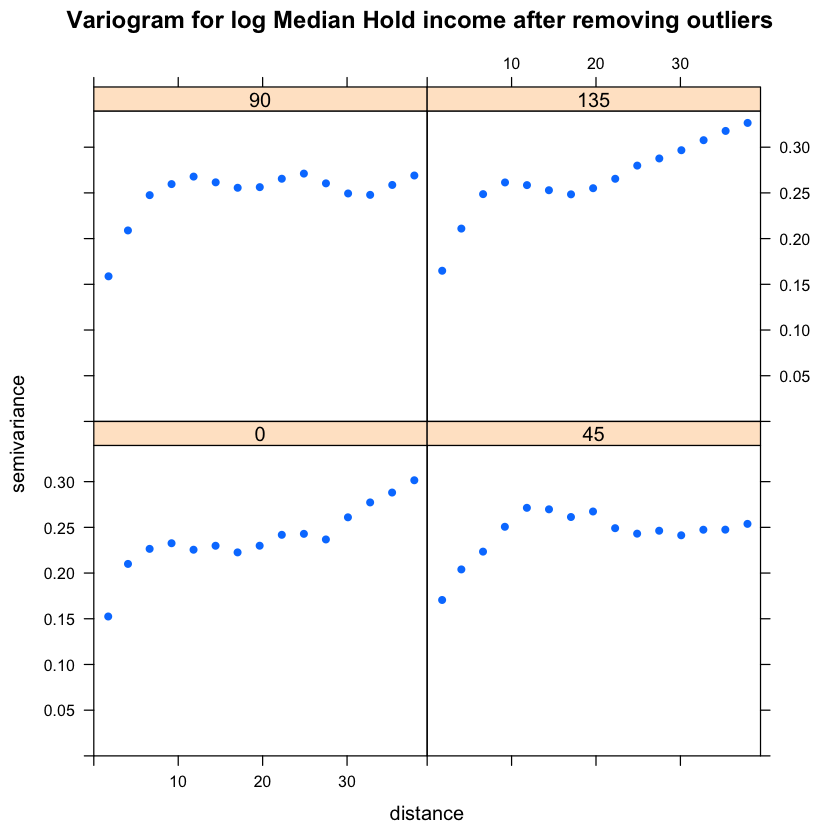

  model     psill    range
1   Exp 0.2494511 1.775872


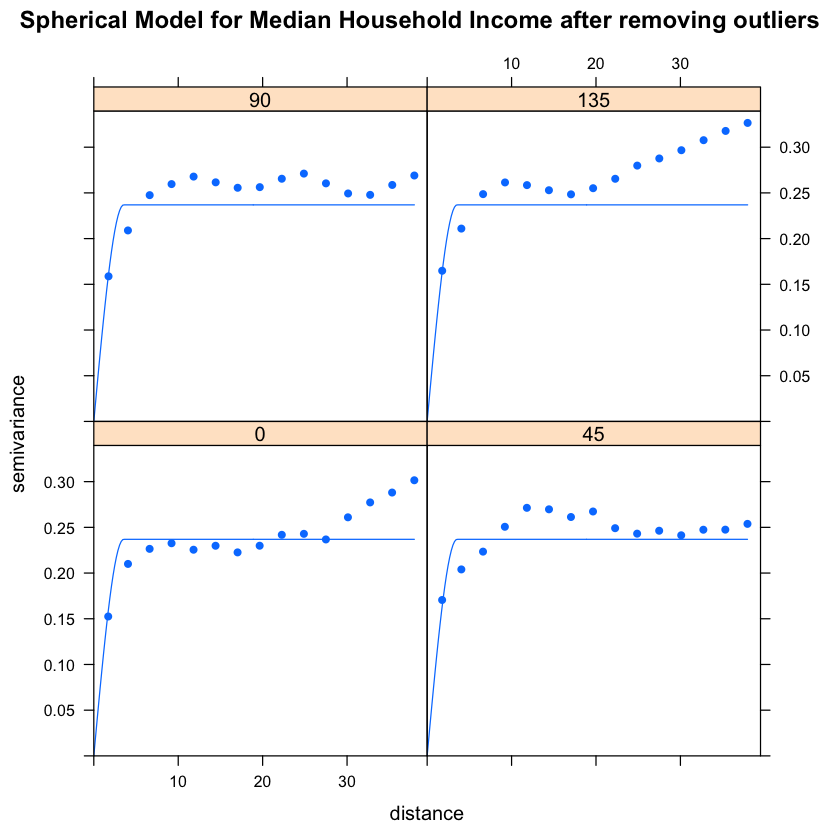

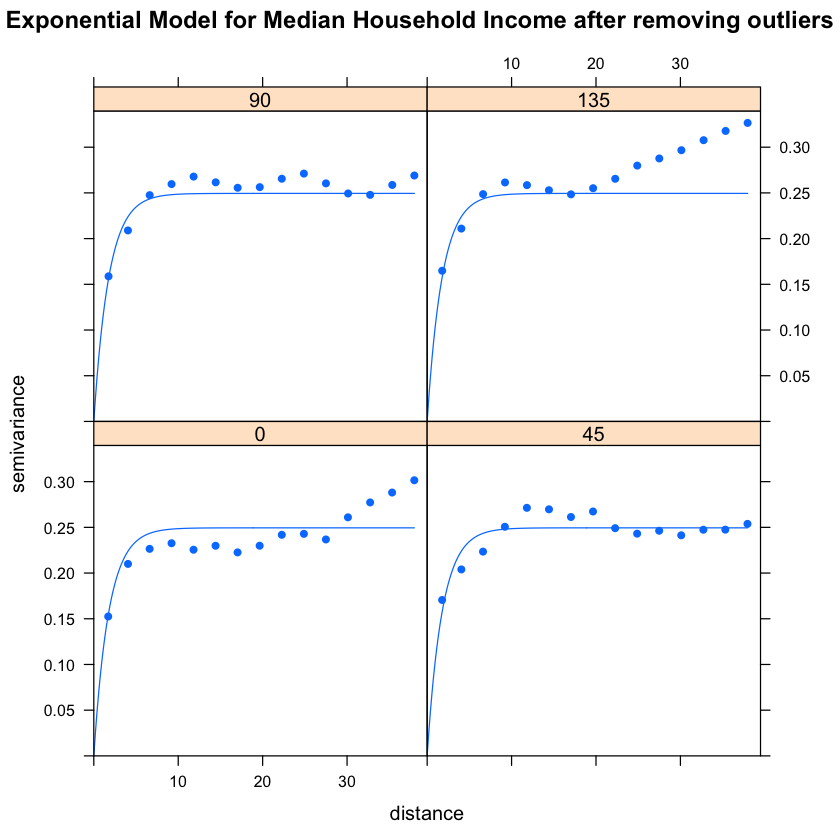

In [12]:
## variogram 
harris_vgm <- gstat::variogram(log(MedHHinc)~1, 
                               censusBoundary.harris_clean, 
                               alpha = c(0, 45, 90, 135))
harris_vgm_rm_ol <- gstat::variogram(log(MedHHinc)~1, 
                                     censusBoundary.harris_clean_rm_ol, 
                                     alpha = c(0, 45, 90, 135))

plot(harris_vgm, main = 
     "Variogram for log Median Hold income", 
     pch = 16)
plot(harris_vgm_rm_ol, main = 
     "Variogram for log Median Hold income after removing outliers", 
     pch = 16)

mmhi_fit_sph <- gstat::fit.variogram(harris_vgm_rm_ol, 
                                      model = gstat::vgm(model =  "Sph"))
print(mmhi_fit_sph)
plot(harris_vgm_rm_ol, mmhi_fit_sph, 
     main = "Spherical Model for Median Household Income after removing outliers", 
     pch = 16)

mmhi_vgm_exp <- gstat::fit.variogram(harris_vgm_rm_ol, 
                                     model = gstat::vgm(model =  "Exp"))
print(mmhi_vgm_exp)
plot(harris_vgm_rm_ol, mmhi_vgm_exp, 
     main = "Exponential Model for Median Household Income after removing outliers", 
     pch = 16)



Using ordinary kriging, fitting model with changing direction in plane (x,y) in positive 45 or 90 degrees clockwise from positive y (North) seems to be the best. (Both Spherical Model and Exponential Model)

Based on these conclusion, we can use the conclusion we got last time for interpolation.

For Vignette purpose, only model with changing direction in plane (x,y) in positive 45 degrees clockwise from positive y (North) will be used.

### Spherical Model 

In [13]:
harris_vgm <- gstat::variogram(log(MedHHinc)~1, 
                               censusBoundary.harris_clean, 
                               alpha = 45)
harris_vgm_rm_ol <- gstat::variogram(log(MedHHinc)~1, 
                                     censusBoundary.harris_clean_rm_ol, 
                                     alpha = 45)
mmhi_fit_sph_rm_ol <- gstat::fit.variogram(harris_vgm_rm_ol, 
                                      model = gstat::vgm(model =  "Sph"))
mmhi_fit_sph <- gstat::fit.variogram(harris_vgm, 
                                      model = gstat::vgm(model =  "Sph"))

census_grid <- sp::spsample(x=censusBoundary.harris_clean,
                            10000, type="regular")
gridded(census_grid) <- TRUE
proj4string(census_grid) <- proj4string(censusBoundary.harris)

mmhi_krig_sph <- gstat::krige(MedHHinc~1, 
                              censusBoundary.harris_clean_rm_ol, 
                              census_grid, 
                              model = mmhi_fit_sph)



[using ordinary kriging]


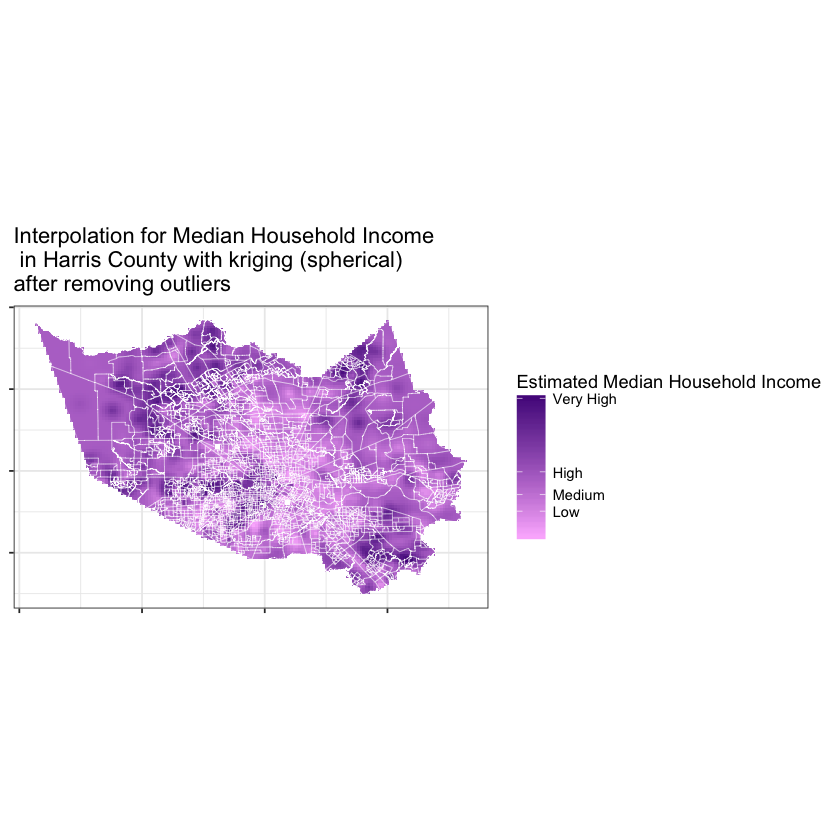

In [14]:
krig_sph.output <- as.data.frame(mmhi_krig_sph)

krig_sph_plot <- ggplot() + 
  geom_tile(data = krig_sph.output %>%
            rename(`Estimated Median Household Income`=var1.pred), 
            aes(x = x1, y = x2, fill = `Estimated Median Household Income`)) + 
  #scale_fill_distiller(palette = "Spectral", direction = 1) +
  scale_fill_gradient(low = "plum1", high = "purple4", 
                      breaks = quantile(censusBoundary.harris_clean_rm_ol@data$MedHHinc),
                      labels=c("Very Low", "Low", "Medium", "High", "Very High")) +
  theme_bw()  +
  coord_equal() 

HarrisCty.tidy <- ggplot2::fortify(censusBoundary.harris_clean, region="id")

HarrisCty.tidy_merge <- merge(HarrisCty.tidy, censusBoundary.harris_clean@data, by="id")

new_plot <- krig_sph_plot +
  geom_path(data=HarrisCty.tidy_merge, 
            aes(long,lat,group=group), 
            color = "white", size=0.1) +
  theme(axis.title = element_blank(), 
        axis.text = element_blank()) +
  labs(title = "Interpolation for Median Household Income\n in Harris County with kriging (spherical)\nafter removing outliers")

new_plot

Looks far better than IDW!

### Exponential Model 

In [15]:
harris_vgm <- gstat::variogram(log(MedHHinc)~1, 
                               censusBoundary.harris_clean, 
                               alpha = 45)
harris_vgm_rm_ol <- gstat::variogram(log(MedHHinc)~1, 
                                     censusBoundary.harris_clean_rm_ol, 
                                     alpha = 45)
mmhi_fit_exp_rm_ol <- gstat::fit.variogram(harris_vgm_rm_ol, 
                                      model = gstat::vgm(model =  "Exp"))
mmhi_fit_exp <- gstat::fit.variogram(harris_vgm, 
                                      model = gstat::vgm(model =  "Exp"))

# using "grid" as new data
census_grid <- sp::spsample(x=censusBoundary.harris_clean,
                            10000, type="regular")
gridded(census_grid) <- TRUE
proj4string(census_grid) <- proj4string(censusBoundary.harris)

mmhi_krig_exp <- gstat::krige(MedHHinc~1, 
                              censusBoundary.harris_clean_rm_ol, 
                              census_grid, 
                              model = mmhi_fit_exp)



[using ordinary kriging]


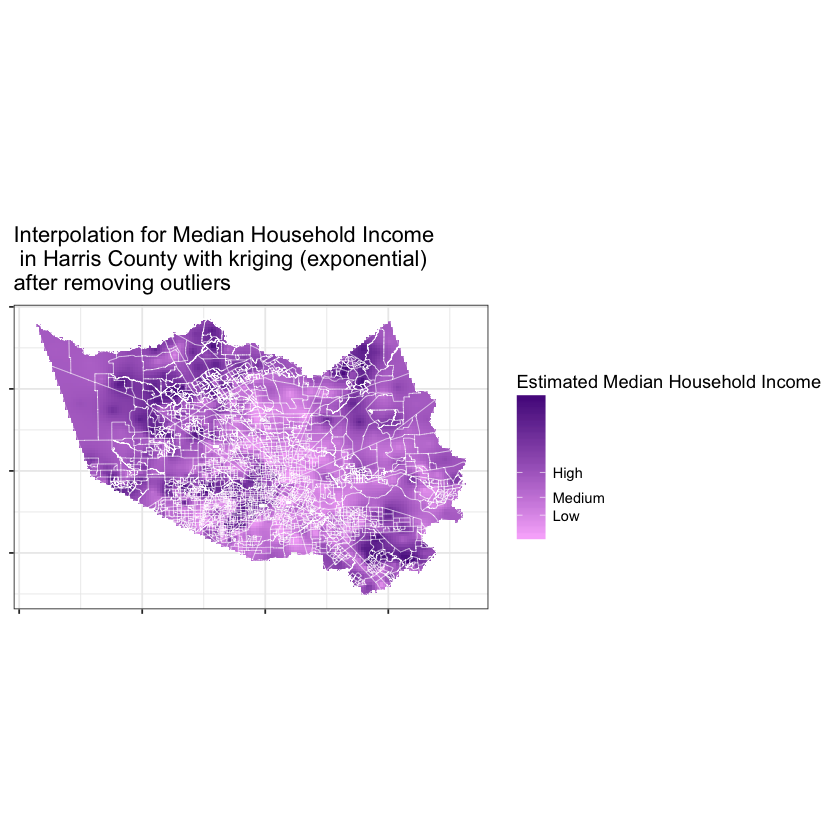

In [16]:
krig_exp.output <- as.data.frame(mmhi_krig_exp)
krig_exp_plot <- ggplot() + 
  geom_tile(data = krig_exp.output %>%
            rename(`Estimated Median Household Income`=var1.pred), 
            aes(x = x1, y = x2, fill = `Estimated Median Household Income`)) + 
  #scale_fill_distiller(palette = "Spectral", direction = 1) +
  scale_fill_gradient(low = "plum1", high = "purple4", 
                      breaks = quantile(censusBoundary.harris_clean_rm_ol@data$MedHHinc),
                      labels=c("Very Low", "Low", "Medium", "High", "Very High")) +
  theme_bw()  +
  coord_equal() 

HarrisCty.tidy <- ggplot2::fortify(censusBoundary.harris_clean, region="id")

HarrisCty.tidy_merge <- merge(HarrisCty.tidy, censusBoundary.harris_clean@data, by="id")

new_plot <- krig_exp_plot +
  geom_path(data=HarrisCty.tidy_merge, aes(long,lat,group=group), 
            color = "white", size=0.1) +
  theme(axis.title = element_blank(), axis.text = element_blank()) +
  labs(title = "Interpolation for Median Household Income\n in Harris County with kriging (exponential)\nafter removing outliers")

new_plot

# Reference

American Community Survey (ACS) 2010. Urban Data Platform, Kinder Institute for Urban Research. https://www.kinderudp.org/#/datasetCatalog/8koe0a2ka4qb

SoS Notebook: An Interactive Multi-Language Data Analysis Environment. Bo Peng, Gao Wang, Jun Ma, Man Chong Leong, Chris Wakefield, James Melott, Yulun Chiu, Di Du, and John N. Weinstein, Bioinformatics, May 2018. doi: https://doi.org/10.1093/bioinformatics/bty405

Using R — Working with Geospatial Data (and ggplot2). Bethany Yollin http://mazamascience.com/WorkingWithData/?p=1494

Notes and code example from STAT 551.

Introduction to Kriging in R. Nabil A. https://rpubs.com/nabilabd/118172

Practical 11: Interpolating Point Data in R. https://www.cdrc.ac.uk/wp-content/uploads/2016/11/Practical_11.html

https://www.stat.berkeley.edu/~arturof/Teaching/STAT248/lab10_part2.html

Intro to spatial data in R - Open and plot raster and vector data with base plot. Leah A. Wasser https://nceas.github.io/oss-lessons/spatial-data-gis-law/4-tues-spatial-analysis-in-r.html
